In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
def extract_mfcc_from_files(audio_folder, n_mfcc=13, max_len=100):
    features = []
    labels = []

    audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

    for file in tqdm(audio_files):
        try:
            label = file.split('_')[0]

            path = os.path.join(audio_folder, file)
            y, sr = librosa.load(path, sr=None)

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)

            combined = np.vstack([mfcc, delta, delta2]).T  # (time, 39)

            # Pad or truncate to fixed length
            if combined.shape[0] < max_len:
                pad = max_len - combined.shape[0]
                combined = np.pad(combined, ((0, pad), (0, 0)), mode='constant')
            else:
                combined = combined[:max_len, :]

            combined = combined[..., np.newaxis]  # (time, 39, 1)

            features.append(combined)
            labels.append(label)
        except Exception as e:
            print(f"Error in file {file}: {e}")

    return np.array(features), np.array(labels)


In [ ]:
data_path = r"E:\NU\Sem6\MachineLearning\Project\New folder\5_EMOTIONS"
X_all, y_all = extract_mfcc_from_files(data_path)
print(X_all.shape, y_all.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45935/45935 [19:36<00:00, 39.04it/s]


(45935, 100, 39, 1) (45935,)


In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)
y_cat = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)

input_shape = (100, 39, 1)
num_classes = y_cat.shape[1]


In [ ]:

def build_conv2d_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_conv2d_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Habiba Yahya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 39, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 39, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 19, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 19, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 9, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 9, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 9, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,725 (432.52 KB)

 Trainable params: 110,277 (430.77 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 192s 330ms/step - accuracy: 0.5317 - loss: 1.1120 - val_accuracy: 0.6149 - val_loss: 0.9241 - learning_rate: 0.0010
Epoch 2/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 202s 330ms/step - accuracy: 0.6533 - loss: 0.8630 - val_accuracy: 0.5126 - val_loss: 1.3539 - learning_rate: 0.0010
Epoch 3/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 191s 333ms/step - accuracy: 0.6889 - loss: 0.7844 - val_accuracy: 0.7075 - val_loss: 0.7528 - learning_rate: 0.0010
Epoch 4/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 193s 335ms/step - accuracy: 0.7203 - loss: 0.7182 - val_accuracy: 0.7101 - val_loss: 0.7617 - learning_rate: 0.0010
Epoch 5/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 186s 323ms/step - accuracy: 0.7385 - loss: 0.6775 - val_accuracy: 0.6189 - val_loss: 1.0342 - learning_rate: 0.0010
Epoch 6/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 188s 328ms/step - accuracy: 0.7529 - loss: 0.6402 - val_accuracy: 0.7654 - val_loss: 0.6136 - learning_rate: 0.0010
Epoch 7/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 203s 328ms/step - accura

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8399 - loss: 0.4417
Test accuracy: 0.8418


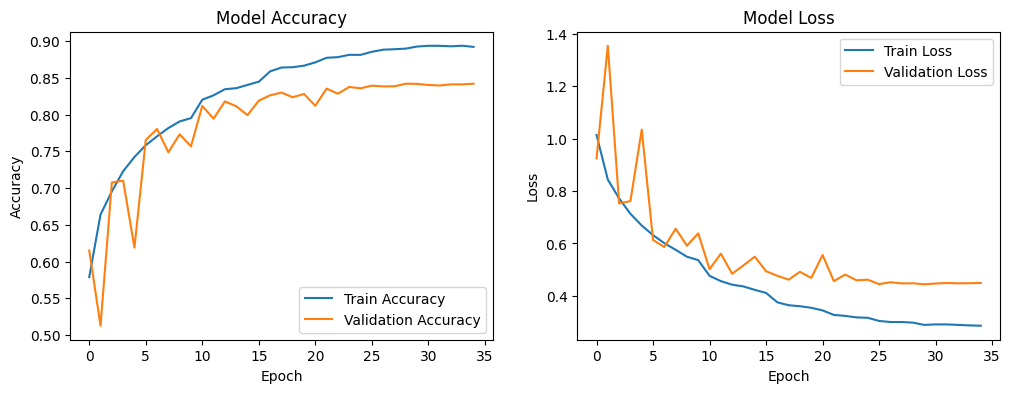

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('training_history.png')
plt.show()